# Generate solar scenarios by fitting a probability distribution to each timestep.

This notebook is the initial prototyping notebook for generating solar scenarios based on each timestep. There is a total of 48 timesteps of 0.5 hour intervals for each solar scenario.

This notebook includes the visualization of:

1. How the probability distributions fit the Malaysia solar data provided, and also
2. Generated scenarios

The final step in this notebook includes scenario reduction from 100 to 10 scenarios.

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
filename = "../Data/Irradiance_39.xlsx"

# read data from excel file, and from columns A to E
df = pd.read_excel(filename, index_col=0, usecols="A:E")

# drop the "Ghi Prev Day" column
df.drop("Ghi Prev Day", axis=1, inplace=True)

# group the data by season and separate them into different dataframes
df_1 = df[df["Season"] == 1]
df_2 = df[df["Season"] == 2]
df_3 = df[df["Season"] == 3]

# drop the "Season" column
df_1.drop("Season", axis=1, inplace=True)
df_2.drop("Season", axis=1, inplace=True)
df_3.drop("Season", axis=1, inplace=True)

# normalize Ghi Curr Day to between 0 and 1, record the min and max values for scaling
min_irradiance = df["Ghi Curr Day"].min()
max_irradiance = df["Ghi Curr Day"].max()
df["Ghi Curr Day"] = (df["Ghi Curr Day"] - df["Ghi Curr Day"].min()) / (df["Ghi Curr Day"].max() - df["Ghi Curr Day"].min())

/var/folders/4f/ll38rx255klcxftt254q2vwh0000gn/T/ipykernel_97969/1871853479.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop("Season", axis=1, inplace=True)
/var/folders/4f/ll38rx255klcxftt254q2vwh0000gn/T/ipykernel_97969/1871853479.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.drop("Season", axis=1, inplace=True)
/var/folders/4f/ll38rx255klcxftt254q2vwh0000gn/T/ipykernel_97969/1871853479.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

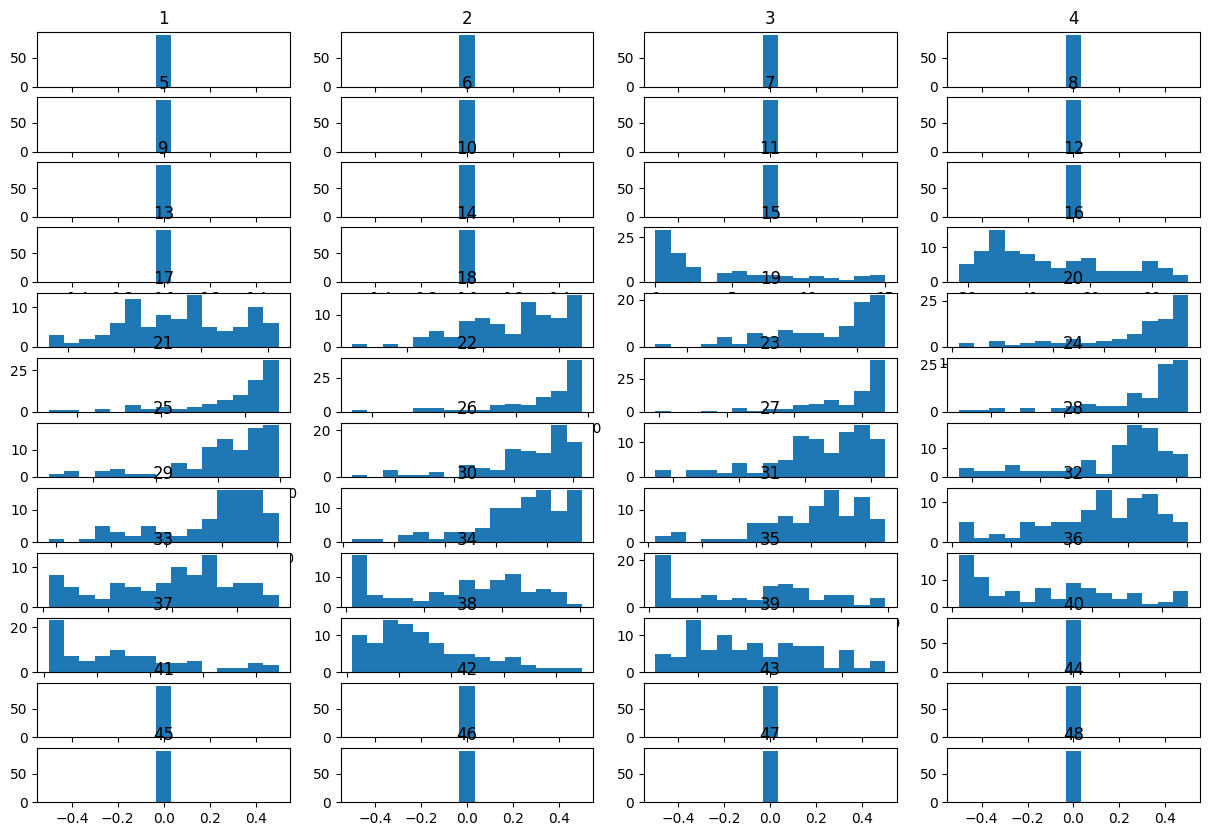

In [3]:
# groupby df_1 by "Time" and plot histogram of every group in subplots
fig, axes = plt.subplots(12, 4, figsize=(15, 10))
for i, (name, group) in enumerate(df_1.groupby("Time")):
    ax = axes[i // 4, i % 4]
    ax.hist(group["Ghi Curr Day"], bins=15)
    ax.set_title(name)
    


/opt/homebrew/Caskroom/miniforge/base/envs/me555/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


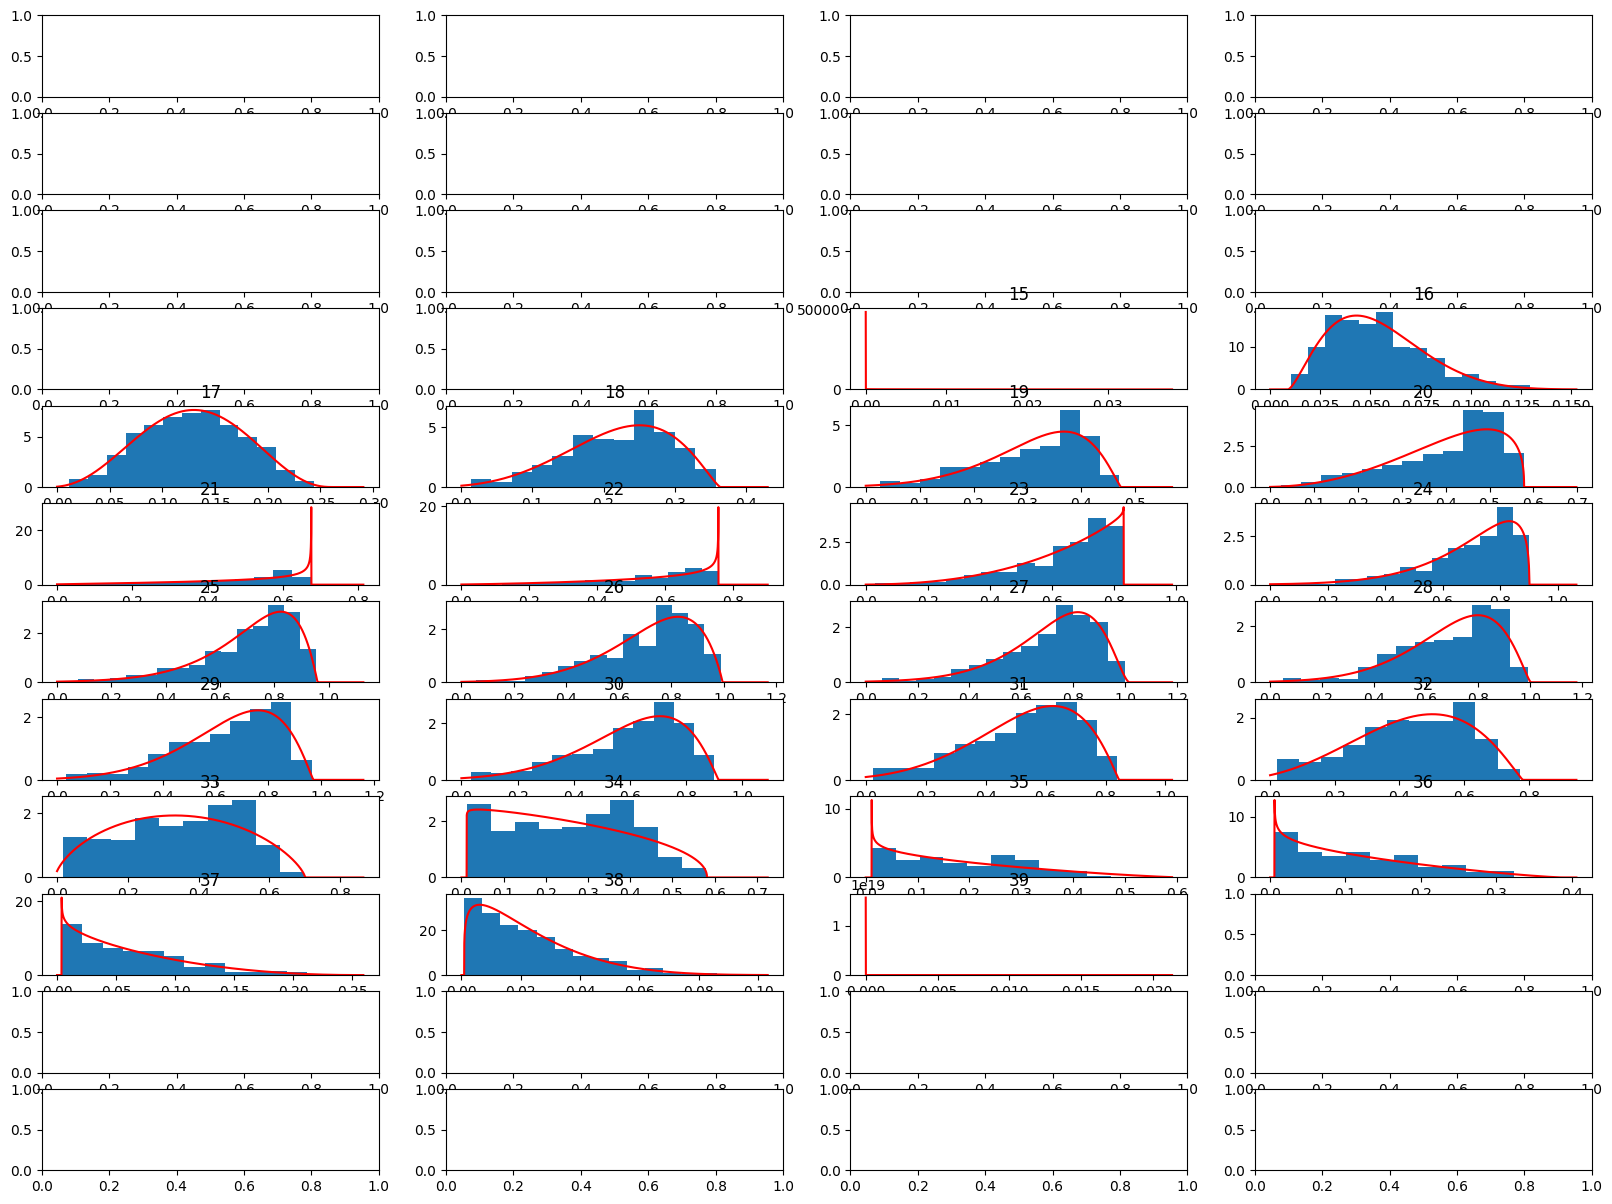

In [4]:
#  for each group, fit a beta distribution to the data
#  and plot the fitted distribution on top of the histogram
#  for each group
fig, axes = plt.subplots(12, 4, figsize=(20, 15))
for i, (name, group) in enumerate(df.groupby("Time")):
    # clear a, b , loc, scale
    a, b, loc, scale = None, None, None, None
    ax = axes[i // 4, i % 4]
    max_x = max(group["Ghi Curr Day"])
    std_x = np.std(group["Ghi Curr Day"])
    x = np.linspace(0, max_x + 1*std_x, 2000)
    # if the group contains only zeros, skip it
    if group["Ghi Curr Day"].sum() > 0:
        # fit a beta distribution to the data
        
        # plot histogram normalized to 1
        ax.hist(group["Ghi Curr Day"], bins='auto', density=True)

        # x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

        a, b, loc, scale = scipy.stats.beta.fit(group["Ghi Curr Day"])
        
        # plot the fitted distribution normalized in the y axis
        ax.plot(x, scipy.stats.beta.pdf(x, a, b, loc, scale), color="red")
        ax.set_title(name)
    
    

In [5]:
#  for each group, if a beta distribution is fitted, set fitted flag of dictionary to True
fit_dict = {}
for i, (name, group) in enumerate (df.groupby("Time")):
    fit_dict[name] = {}
    # clear a, b , loc, scale
    a, b, loc, scale = None, None, None, None
    max_x = max(group["Ghi Curr Day"])
    min_x = min(group["Ghi Curr Day"])
    std_x = np.std(group["Ghi Curr Day"])
    x = np.linspace(0, max_x + 1*std_x, 2000)
    # normalize group["Ghi Curr Day"] which is the irradiance
    # normalized_irradiance = (group["Ghi Curr Day"] - min_x) / (max_x - min_x)
    
    # if the group contains only zeros, skip it
    if group["Ghi Curr Day"].sum() > 0:
        # fit a beta distribution to the data
        a, b, loc, scale = scipy.stats.beta.fit(group["Ghi Curr Day"], floc=0)
        # set fitted flag to True
        fit_dict[name]["fit"] = True
        # get parameters of beta distribution into the dictionary
        fit_dict[name]["params"] = [a, b, loc, scale]
    else:
        fit_dict[name]["fit"] = False
        fit_dict[name]["params"] = [None, None, None, None]


/opt/homebrew/Caskroom/miniforge/base/envs/me555/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [6]:
# keys of fitdict is the t'th interval of the day, [1, 48]
fit_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [7]:
# turn df into scenarios of Ghi Curr Day, 48 time intervals

T_irradiance_list = []
for i, (name, group) in enumerate(df.groupby("Time")):
    T_irradiance_list.append(group["Ghi Curr Day"].values)

# turn T_irradiance list into a 2d array 
T_irradiance = np.array(T_irradiance_list)

# check the maximum difference between irradiance of subsequent time intervals
max_diff_dict = {}
max_diff = 0
for i in range(47):
    max_diff = max(T_irradiance[i+1] - T_irradiance[i])
    print("max_diff: ", max_diff, "at i: ", i)
    max_diff_dict[i] = max_diff


max_diff:  0.0 at i:  0
max_diff:  0.0 at i:  1
max_diff:  0.0 at i:  2
max_diff:  0.0 at i:  3
max_diff:  0.0 at i:  4
max_diff:  0.0 at i:  5
max_diff:  0.0 at i:  6
max_diff:  0.0 at i:  7
max_diff:  0.0 at i:  8
max_diff:  0.0 at i:  9
max_diff:  0.0 at i:  10
max_diff:  0.0 at i:  11
max_diff:  0.0 at i:  12
max_diff:  0.031639501438159155 at i:  13
max_diff:  0.10067114093959732 at i:  14
max_diff:  0.15340364333652923 at i:  15
max_diff:  0.19271332694151488 at i:  16
max_diff:  0.19463087248322147 at i:  17
max_diff:  0.22722914669223393 at i:  18
max_diff:  0.286673058485139 at i:  19
max_diff:  0.25982742090124644 at i:  20
max_diff:  0.4228187919463087 at i:  21
max_diff:  0.33365292425695114 at i:  22
max_diff:  0.29242569511025884 at i:  23
max_diff:  0.26174496644295303 at i:  24
max_diff:  0.43144774688398846 at i:  25
max_diff:  0.3326941514860978 at i:  26
max_diff:  0.3326941514860978 at i:  27
max_diff:  0.33173537871524444 at i:  28
max_diff:  0.24065196548418022 at

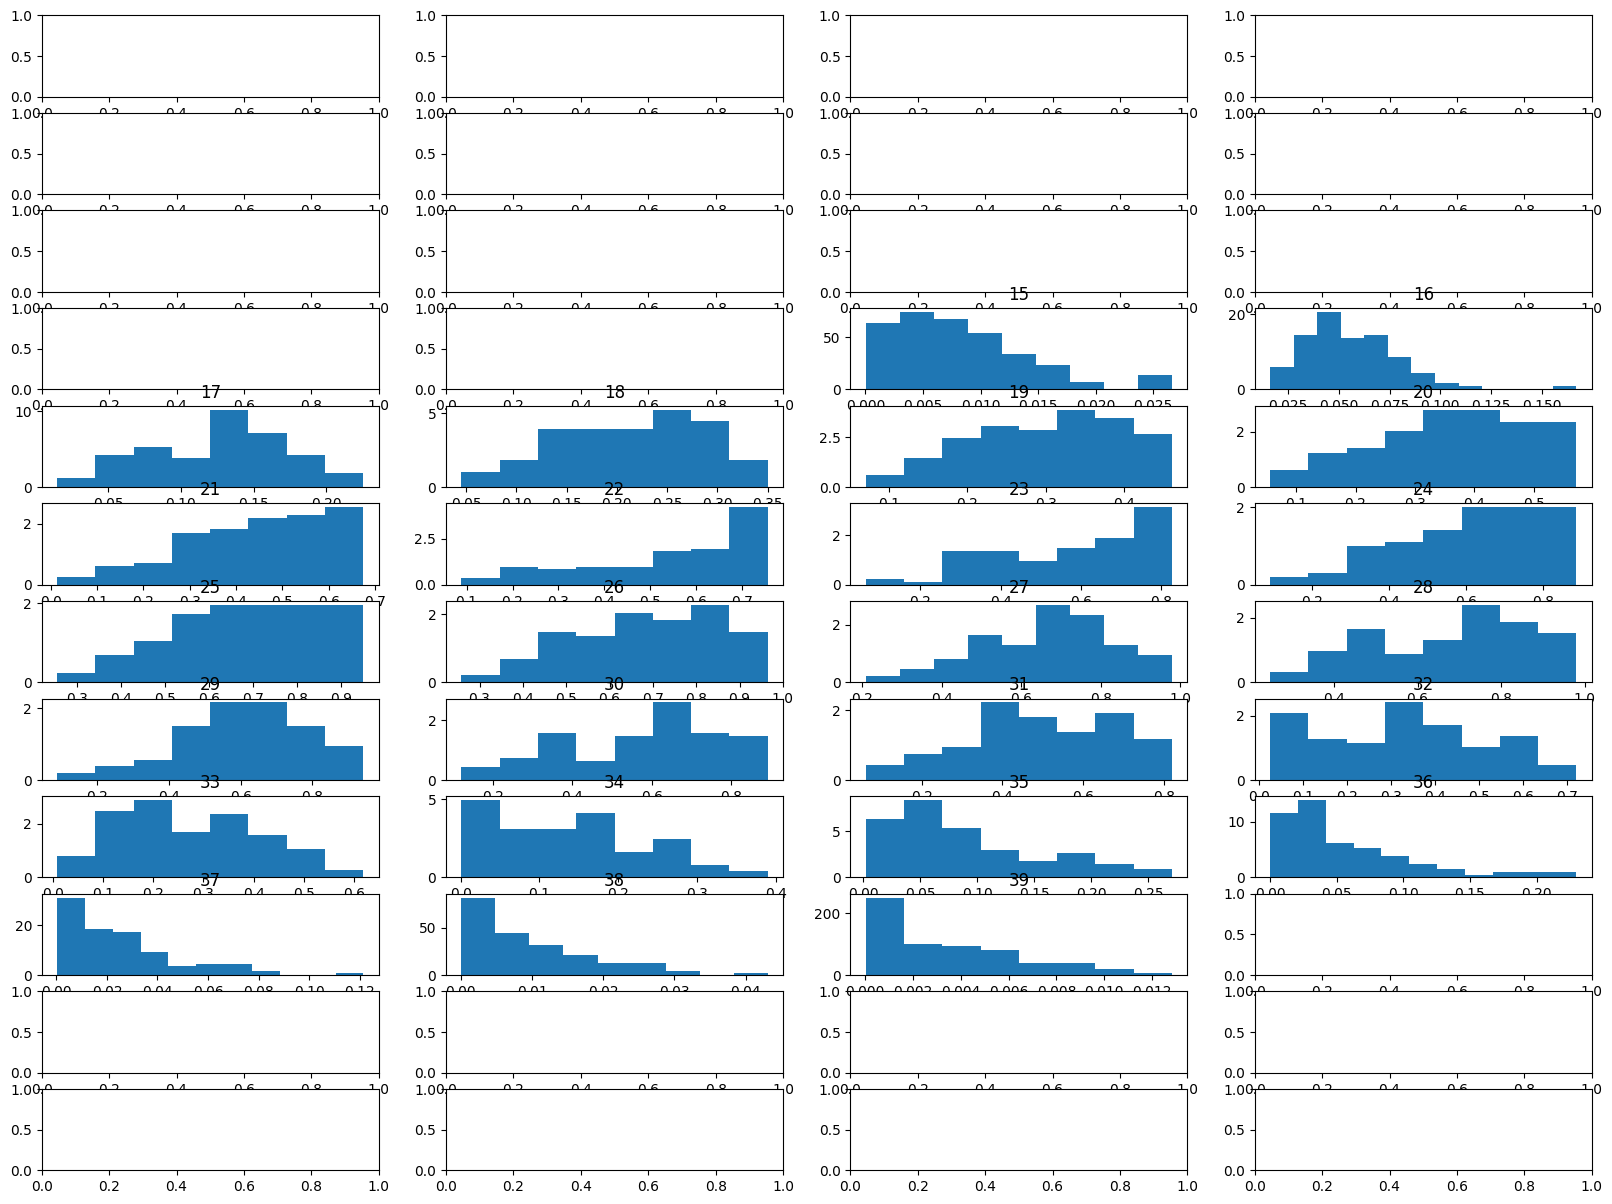

In [47]:
# for each time interval, use the corresponding distribution to sample 10 points, equivalent to 10 scenario
# and plot the histogram of the sampled points. Add the samples into a numpy array
nScenarios = 100
scenarios = np.zeros((48, nScenarios)) # 48 time intervals, 100 scenarios
fig, axes = plt.subplots(12, 4, figsize=(20, 15))
for i, (name, group) in enumerate(df.groupby("Time")):
    ax = axes[i // 4, i % 4]
    # if the group contains only zeros, skip it
    if group["Ghi Curr Day"].sum() > 0:
        # get the parameters of the fitted distribution
        a, b, loc, scale = fit_dict[name]["params"]
        # sample 10 points from the distribution
        samples = scipy.stats.beta.rvs(a, b, loc, scale, size=nScenarios)

        # if the difference in irradiance between previous time step and current timestep is greater than 0.44
        # resample the respective points until the difference is less than 0.44
        while(np.max(samples - scenarios[i-1]) > max_diff_dict[name]):
            # get the indices of the points that need to be resampled
            idx = np.where(samples - scenarios[i-1] > max_diff_dict[name])[0]
            # resample the points
            samples[idx] = scipy.stats.beta.rvs(a, b, loc, scale, size=len(idx))
            

        # add the samples to the scenarios array
        scenarios[i] = samples
        # plot the histogram of the sampled points
        ax.hist(samples, bins='auto', density=True)
        ax.set_title(name)
    else:
        # sample zeros instead
        samples = np.zeros(nScenarios)
        scenarios[i] = samples 

In [48]:
# check which column has negative values
np.where(scenarios < 0)

(array([], dtype=int64), array([], dtype=int64))

In [49]:
#  check max diff of scenarios
max_diff = 0
for i in range(47):
    diff = max(scenarios[i+1] - scenarios[i])
    if diff > max_diff:
        max_diff = diff
        print("max_diff: ", max_diff, "at i: ", i)

max_diff:  0.026628721842820134 at i:  13
max_diff:  0.16300568292085174 at i:  14
max_diff:  0.1870486993984245 at i:  15
max_diff:  0.22125652905493104 at i:  16
max_diff:  0.28146798480057966 at i:  17
max_diff:  0.41192280407133247 at i:  19
max_diff:  0.42645410212124757 at i:  23


In [50]:
# scale the scenarios to the original irradiance range, and convert to kW by multiplying 0.0005
for i in range(48):
    scenarios[i] = scenarios[i] * (max_irradiance - min_irradiance) + min_irradiance

In [60]:
import numpy as np
import scenario_reduction as scen_red

S = scen_red.ScenarioReduction(scenarios, probabilities=None, cost_func='General', r = 2)
S.fast_forward_sel(n_sc_red=10, num_threads = 4)  # use fast forward selection algorithm to reduce to 10 scenarios with 4 threads 
scenarios_reduced = S.scenarios_reduced  # get reduced scenarios
probabilities_reduced = S.probabilities_reduced  # get reduced probabilities


In [61]:
probabilities_reduced

array([0.15, 0.1 , 0.1 , 0.12, 0.11, 0.08, 0.13, 0.06, 0.08, 0.07])

Text(0.5, 1.0, 'Solar Power Output of 100 simulated scenarios')

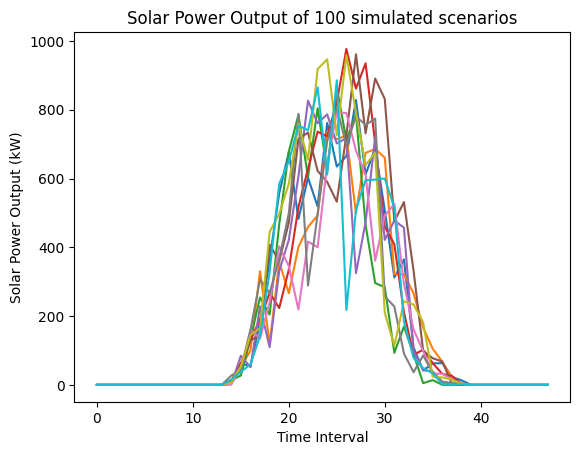

In [62]:
# plot the 10 scenarios
plt.plot(scenarios_reduced)
plt.xlabel("Time Interval")
plt.ylabel("Solar Power Output (kW)")
plt.title("Solar Power Output of 100 simulated scenarios")

In [106]:
# save transposed scenarios numpy array to csv
np.savetxt("Data/scenarios.csv", scenarios.T, delimiter=",")

In [107]:
# check for negative numbers in scenarios
np.any(scenarios < 0)

False

Text(0.5, 1.0, 'Solar Power Output of original 1 year data (kW)')

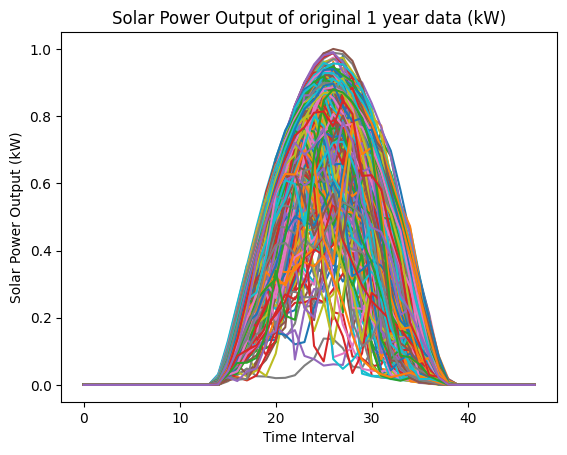

In [23]:
plt.plot(T_irradiance)
plt.xlabel("Time Interval")
plt.ylabel("Solar Power Output (kW)")
plt.title("Solar Power Output of original 1 year data (kW)")